<h1> Load the data </h1>


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from coffea.nanoevents import NanoEventsFactory, DelphesSchema
import numpy as np
import uproot
import ROOT
import awkward as ak
import funcs
from hist import Hist, axis
import os


tree_name= "Delphes"  #all of them are named delphes

#Signal
signal_folder = "data/signal/"
signal_filename =  "VBF_DM_My0_1000_MXD_10.root"
signal_file = uproot.open(signal_folder +signal_filename)

#Background
background_folder = "data/bkg/"


#will store data to be used in final "cut chart"
num_cuts = 5
SM_events = [1000,700,200]
NP_events = [500,400,300]
Significance = [1,2.4,5]
    #all this is temp for now




<h1> Bins </h1>

In [51]:
binning = {
    "PT": {"range": (20, 300), "bins": 14},  # (300 - 20) / 20 = 14 bins
    "Eta*Eta": {"range": (-25, 25), "bins": 500},  # (25 - (-25)) / 0.1 = 500 bins
    "Delta_Eta": {"range": (0, 10), "bins": 100},  # (10 - 0) / 0.1 = 100 bins
    "Transverse": {"range": (500, 2000), "bins": 75},  # (2000 - 500) / 20 = 75 bins
    "Eta": {"range": (-5, 5), "bins": 100},  # (5 - (-5)) / 0.1 = 100 bins
    "Phi": {"range": (0, 2 * np.pi), "bins": 63}  # (2 * pi - 0) / 0.1 = 63 bins
}

plt.figure(figsize=(10, 6))



<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<h1> Plot Everything</h1>

<h3> MET met <h3>

<h3> MET Phi </h3>

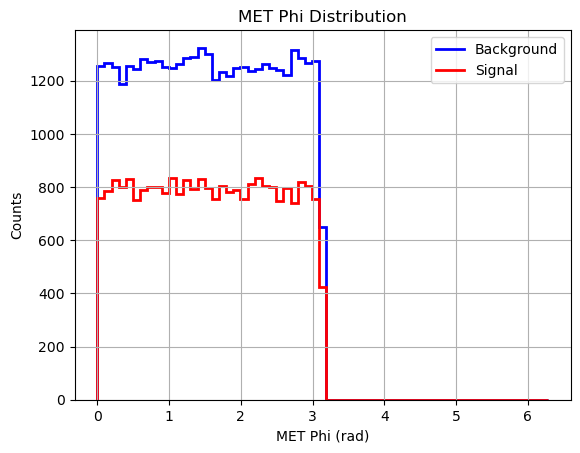

In [110]:
# Create histograms
met_phi_hist_background = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)
met_phi_hist_signal = Hist(
    axis.Regular(binning["Phi"]["bins"], *binning["Phi"]["range"], name="MET_Phi", label="MET Phi (rad)")
)

#Signal
#Signal Data
signal_tree = signal_file[tree_name]
signal_weights = signal_tree["Event/Event.Weight"].array(library="np")
normalized_signal_weights = signal_weights / np.mean(signal_weights)

signal_met_phi = signal_tree["MissingET.Phi"].array(library="np")
met_phi_hist_signal.fill(MET_Phi=signal_met_phi,weight = normalized_signal_weights)


#Background
for root_file in os.listdir(background_folder):
    if root_file.endswith(".root"):
        file_path = os.path.join(background_folder, root_file)
        background_file = uproot.open(file_path)
        background_tree = background_file[tree_name]

        background_weights = background_tree["Event/Event.Weight"].array(library="np")
        normalized_background_weights = background_weights / np.mean(background_weights)

        background_met_phi = background_tree["MissingET.Phi"].array(library="np")
        met_phi_hist_background.fill(MET_Phi=background_met_phi,weight = normalized_background_weights)
        



#Set up histogram

# Background histogram
plt.stairs(
    met_phi_hist_background.values(),
    met_phi_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

# Signal histogram
plt.stairs(
    met_phi_hist_signal.values(),
    met_phi_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=2
)

# Add labels and legend
plt.xlabel('MET Phi (rad)')
plt.ylabel('Counts')
plt.title('MET Phi Distribution')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h2> Jets </h2>

<h3> PT(j0) , PT(j1) </h3>

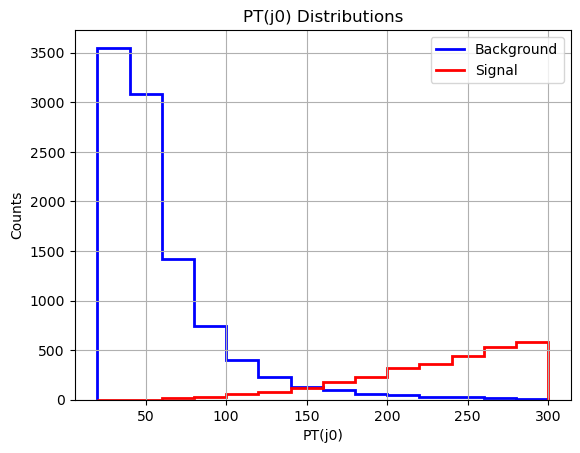

In [119]:
# Create histograms

#J0
pt_j0_hist_background = Hist(
    axis.Regular(binning["PT"]["bins"], *binning["PT"]["range"], name="PT_J0", label="PT_J0")
)
pt_j0_hist_signal = Hist(
    axis.Regular(binning["PT"]["bins"], *binning["PT"]["range"], name="PT_J0", label="PT_J0")
)

#J1
pt_j1_hist_background = Hist(
    axis.Regular(binning["PT"]["bins"], *binning["PT"]["range"], name="PT_J1", label="PT_J1")
)
pt_j1_hist_signal = Hist(
    axis.Regular(binning["PT"]["bins"], *binning["PT"]["range"], name="PT_J1", label="PT_J1")
)


# Signal processing
signal_jets_pt = signal_tree["Jet.PT"].array(library="np")
signal_filtered_jets_pt = [entry for entry in signal_jets_pt if len(entry) >= 2]  # At least two entries
signal_pt_j0 = np.array([entry[0] for entry in signal_filtered_jets_pt])
signal_pt_j1 = np.array([entry[1] for entry in signal_filtered_jets_pt])

# Ensure weights match the number of entries in filtered data
valid_indices = [i for i, entry in enumerate(signal_jets_pt) if len(entry) >= 2]
signal_weights_filtered = np.array([signal_weights[i] for i in valid_indices])
normalized_signal_weights_filtered = signal_weights_filtered / np.mean(signal_weights_filtered)

pt_j0_hist_signal.fill(PT_J0=signal_pt_j0, weight=normalized_signal_weights_filtered[:len(signal_pt_j0)])
pt_j1_hist_signal.fill(PT_J1=signal_pt_j1, weight=normalized_signal_weights_filtered[:len(signal_pt_j1)])


# Background processing
for root_file in os.listdir(background_folder):
    if root_file.endswith(".root"):
        file_path = os.path.join(background_folder, root_file)
        background_file = uproot.open(file_path)
        background_tree = background_file[tree_name]

        # Extract and normalize weights
        background_weights = background_tree["Event/Event.Weight"].array(library="np")
        normalized_background_weights = background_weights / np.mean(background_weights)
        
        # Extract and filter jet PT
        background_jets_pt = background_tree["Jet.PT"].array(library="np")
        background_filtered_jets_pt = [entry for entry in background_jets_pt if len(entry) >= 2]  # At least two entries
        
        # Extract PT J0 and PT J1
        background_pt_j0 = np.array([entry[0] for entry in background_filtered_jets_pt])
        tempy = background_pt_j0
        background_pt_j1 = np.array([entry[1] for entry in background_filtered_jets_pt])

        # Ensure weights match the number of entries in filtered data
        valid_indices = [i for i, entry in enumerate(background_jets_pt) if len(entry) >= 2]
        filtered_weights = np.array([background_weights[i] for i in valid_indices])
        normalized_bkg_filtered_weights = filtered_weights / np.mean(filtered_weights)
        
        # Make sure filtered weights are aligned with filtered data
        if len(background_pt_j0) <= len(normalized_bkg_filtered_weights):
            pt_j0_hist_background.fill(PT_J0=background_pt_j0, weight=normalized_bkg_filtered_weights[:len(background_pt_j0)])
            pt_j1_hist_background.fill(PT_J1=background_pt_j1, weight=normalized_bkg_filtered_weights[:len(background_pt_j1)])

    

#Set up histogram



plt.stairs(
    pt_j0_hist_background.values(),
    pt_j0_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

plt.stairs(
    pt_j0_hist_signal.values(),
    pt_j0_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=2
)

# Add labels and legend
plt.xlabel('PT(j0)')
plt.ylabel('Counts')
plt.title('PT(j0) Distributions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
 



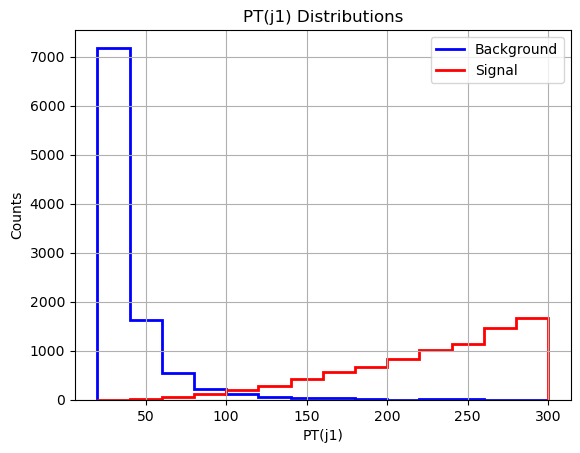

In [120]:
plt.stairs(
    pt_j1_hist_background.values(),
    pt_j1_hist_background.axes[0].edges,
    color='blue',
    label='Background',
    linewidth=2
)

plt.stairs(
    pt_j1_hist_signal.values(),
    pt_j1_hist_signal.axes[0].edges,
    color='red',
    label='Signal',
    linewidth=2
)

# Add labels and legend
plt.xlabel('PT(j1)')
plt.ylabel('Counts')
plt.title('PT(j1) Distributions')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

<h1> Step 3: Iteratively Plot, then Cut <h1>

In [21]:
#Testing stuff

#this is how I might make a cut
trial = signalevents['Jet'][signalevents.Jet.PT > 30].compute()['PT']
trial


<b> $\eta$($j_0$) *  $\eta$($j_1$) </b>

<b> abs($\Delta$($j_0$,$j_1$)) </b>

<b>Pt($j_0$) </b>

<b>Pt($j_1$)</b>

<b> $M_{ET}$, <b>

<h1>Step 5: Compile full Cut Chart </h1>

In [ ]:

column_width = 12  

# Create the grid header
header_row = f"{'Cut #':^{column_width}} | {'SM Events':^{column_width}} | {'NP Events':^{column_width}} | {'Significance':^{column_width}}"
print(header_row)

# Print a separator line
print("-" * (len(header_row) + 1))

#Initial Conditions
init_data = f"{'    Init':{column_width}} | {SM_events[0]:^{column_width}} | {NP_events[0]:^{column_width}} | {Significance[0]:^{column_width}.2f}"  # 
print(init_data)

# Iterate through data and format each row
for i in range(1, num_cuts):  # Use range(1, num_cuts+1) for 1 to num_cuts (inclusive)
    row_data = f"{i:{column_width}} | {SM_events[i]:^{column_width}} | {NP_events[i]:^{column_width}} | {Significance[i]:^{column_width}.2f}" 
    print(row_data)


